In [1]:
!pip install segmentation-models-pytorch
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.3 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=50d67aad1f0227825076388118cd72a64aa77146f78b9269c06272abfbe6ccf3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=937c298277ed366ed27f8b7d27cf0a630b52d1716b33e27cda7b83ab51785573
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [2]:
import os
from glob import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import lightning as pl
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

from pprint import pprint
from torch.utils.data import Dataset, DataLoader

In [3]:
class SegmDataset(Dataset):
    def __init__(self, idx, transform=None):

        img_paths_1 = glob(f'/kaggle/input/segm-ham10000-imgs/segm/HAM10000_images_part_1/*')
        img_paths_2 = glob(f'/kaggle/input/segm-ham10000-imgs/segm/HAM10000_images_part_2/*')

        self.transform = transform
        self.img_paths = list(map((img_paths_1 + img_paths_2).__getitem__, idx))
        self.mask_paths = '/kaggle/input/segm-ham10000-imgs/segm/HAM10000_segmentations_lesion_tschandl'

    def __getitem__(self, index):

        img_path = self.img_paths[index]
        img = Image.open(img_path)
        
        
        img_name = img_path.split('/')[-1].split('.')[0]
        mask_path = f'{self.mask_paths}/{img_name}_segmentation.png'
        mask = np.asarray(Image.open(mask_path))
        
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)

        return {'image': img, 'mask': mask}


    def __len__(self):
        return len(self.img_paths)

In [4]:
train_idx, valid_test_idx = train_test_split(np.arange(10000), test_size=0.3,
                                            random_state=0)
valid_idx, test_idx = train_test_split(valid_test_idx, test_size=0.5,
                                            random_state=0)

train_dataset = SegmDataset(train_idx, transform=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Resize((384, 384))]))
valid_dataset = SegmDataset(valid_idx, transform=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Resize((384, 384))]))
test_dataset = SegmDataset(test_idx, transform=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Resize((384, 384))]))


n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array 

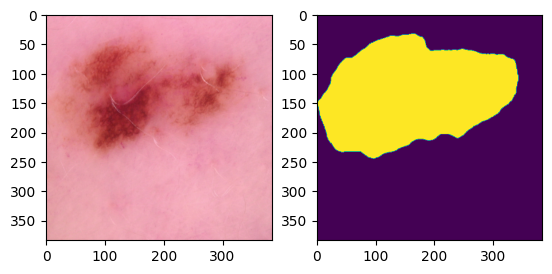

In [5]:
sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(np.array(sample["image"]).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(sample["mask"]).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [35]:
class LesionModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        #prob_mask = logits_mask.sigmoid()
        #pred_mask = (prob_mask > 0.5).float()
        pred_mask = (logits_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [36]:
model = LesionModel("Unet", "resnet34", in_channels=3, out_classes=1)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
trainer = pl.Trainer(
    max_epochs=10,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=True)
pprint(valid_metrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: |          | 0/? [00:00<?, ?it/s]

[{}]


In [20]:
model.eval()
model(valid_dataset[0]['image']).sigmoid()

tensor([[[[7.3413e-03, 7.2437e-04, 7.8988e-04,  ..., 3.6732e-04,
           4.1458e-04, 5.6026e-03],
          [9.5445e-04, 2.7001e-05, 3.1025e-05,  ..., 4.0310e-05,
           2.0049e-05, 4.7902e-04],
          [3.9925e-04, 2.1073e-05, 4.0960e-05,  ..., 9.5598e-05,
           4.7986e-05, 7.9174e-04],
          ...,
          [8.0858e-04, 8.9768e-05, 1.1692e-04,  ..., 3.8744e-05,
           1.2396e-05, 4.1678e-04],
          [7.3815e-04, 5.6342e-05, 5.7366e-05,  ..., 1.3877e-05,
           9.8639e-06, 5.3487e-04],
          [5.8403e-03, 8.9536e-04, 5.1593e-04,  ..., 2.0018e-04,
           2.2551e-04, 5.8464e-03]]]], grad_fn=<SigmoidBackward0>)

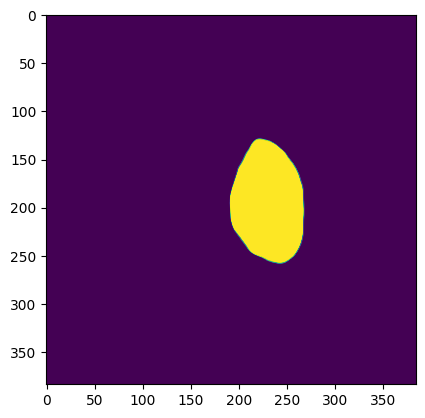

In [22]:
plt.imshow(model(valid_dataset[0]['image']).sigmoid().detach().numpy().squeeze())

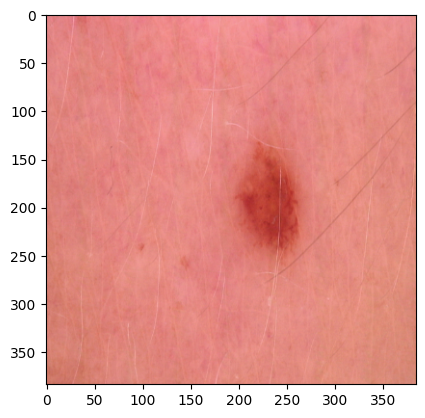

In [24]:
plt.imshow(valid_dataset[0]['image'].numpy().transpose(1, 2, 0))

In [40]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

2024-05-21 20:13:51.190138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 20:13:51.190271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 20:13:51.469075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]


In [39]:
trainer = pl.Trainer(
    max_epochs=10,
)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [32]:
torch.save(model.model.state_dict(), 'unet.pth')

In [7]:
model = smp.create_model(
            "Unet", encoder_name="resnet34" , in_channels=3, classes=1
        )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 272MB/s]


In [8]:
model.load_state_dict(torch.load('/kaggle/input/unet_lesion/pytorch/unet_lesion/1/unet.pth'))

<All keys matched successfully>

In [9]:
model.eval()
probs_mask = model(torch.unsqueeze(valid_dataset[0]['image'],
                                    0)).sigmoid().detach().squeeze()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


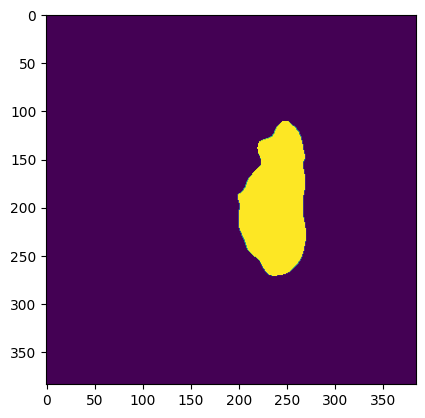

In [10]:
plt.imshow((probs_mask > 0.5).float())

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


# Пример использования
pred_probs_list = []  # Вероятности, предсказанные моделью
true_masks_list = []  # Реальные маски

for i in range(len(test_dataset)):
    print(i)
    pred_probs_list.append(model(torch.unsqueeze(test_dataset[i]['image'].to(device),
                                    0)).cpu().sigmoid().detach().squeeze())
    true_masks_list.append(test_dataset[i]['mask'])
    



0


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [30]:
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_average_precision(pred_probs, true_mask, threshold=0.5):
    pred_mask = pred_probs >= threshold
    precision, recall, _ = precision_recall_curve(true_mask.flatten(), pred_mask.flatten())
    ap = auc(recall, precision)
    return ap

def calculate_mAP50(pred_probs_list, true_masks_list, iou_threshold=0.5):
    assert len(pred_probs_list) == len(true_masks_list), "The number of predictions and true masks must be the same"
    
    aps = []
    
    for pred_probs, true_mask in zip(pred_probs_list, true_masks_list):
        iou = calculate_iou((pred_probs >= 0.5).numpy().astype(float), true_mask.numpy())
        if iou >= iou_threshold:
            ap = calculate_average_precision(pred_probs.numpy().astype(float), true_mask.numpy().astype(int))
            aps.append(ap)
    
    mAP50 = np.mean(aps) if aps else 0.0
    return mAP50


mAP50 = calculate_mAP50(pred_probs_list, true_masks_list)
print(f"mAP50: {mAP50}")

mAP50: 0.8750792507855648
